# Predicting Heart Disease
Heart Disease is the leading cause of death around the world, accounting for 32% of deaths. Many factors 

In this project, I will be using anonymized data from multiple hospitals on several patients to predict whether or not these patients will have heart disease in the future.

The dataset includes relevant information for each patient, such as their personal information and some medical data, including whether or not they have had heart disease before.

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

I will start by briefly looking through the dataset and seeing if there is anything that stands out (whether it would be abnormal or could further contextualize the data)

In [6]:
df = pd.read_csv('heart_disease_prediction.csv')
print(df.loc[:4])
print(df.shape)

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
(918, 12)


In [7]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Some data that stick out and don't look right:
The min Resting BP and cholestrol being 0 (seems impossible)

Next, I will quickly check if there are any null/missing values in the dataset

In [9]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

After this cursory look through the data, I will plot the categorical data to get a better sense of the distributions for each category

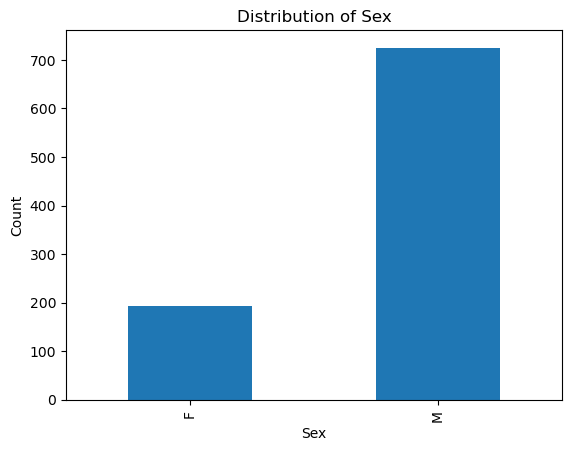

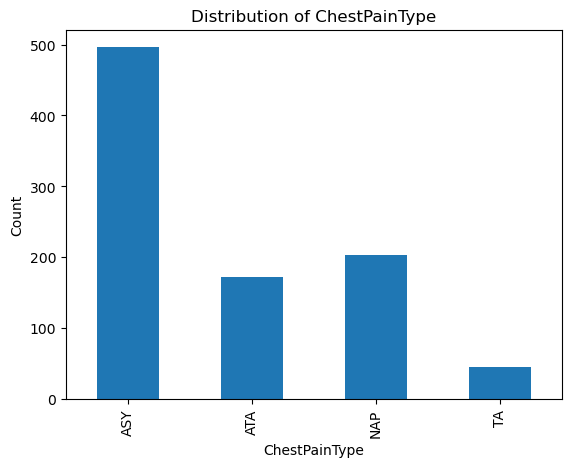

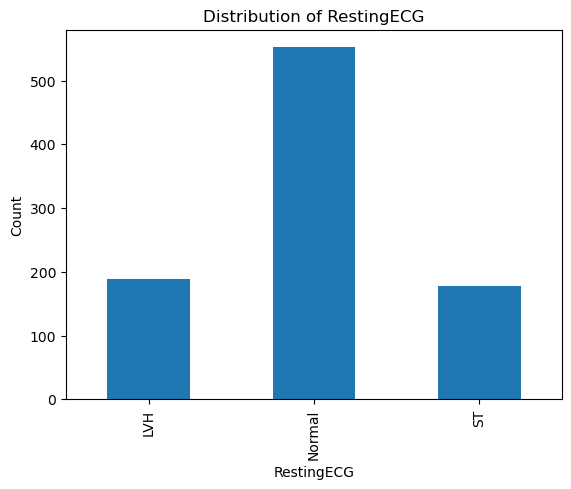

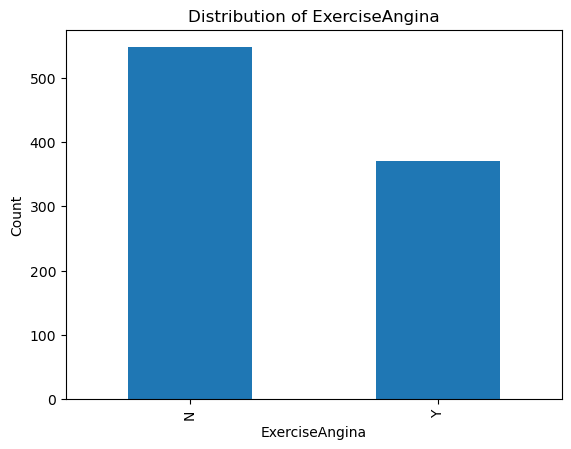

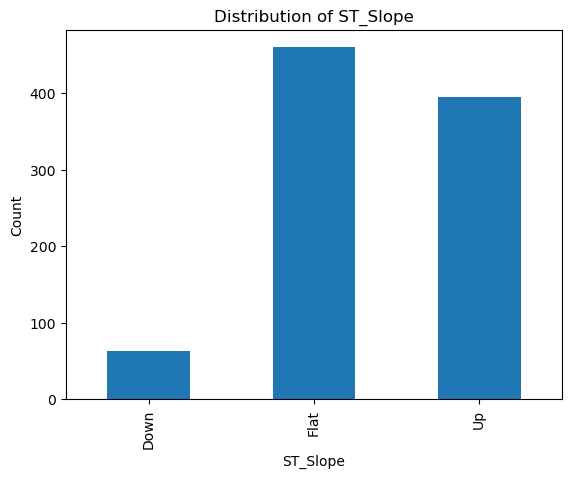

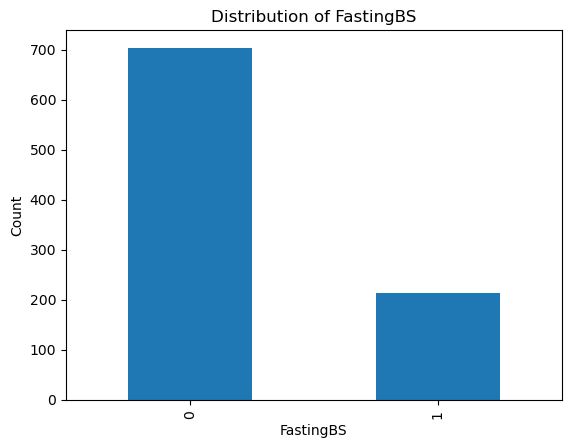

In [11]:
import matplotlib.pyplot as plt

catCols = [col for col in df.columns if df[col].dtype=='object']
catCols += ['FastingBS']

for col in catCols:
    df[col].value_counts().sort_index().plot(kind='bar')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(f'Distribution of {col}')
    plt.show()

From the data above, one thing that immediately stood out to me was the disparity between males and females in the dataset. THere are over 3 times as many males as there are females.

Next, I will group these same categories on whether or not the patient has Heart Disease to see if there are any more insights to be gathered there

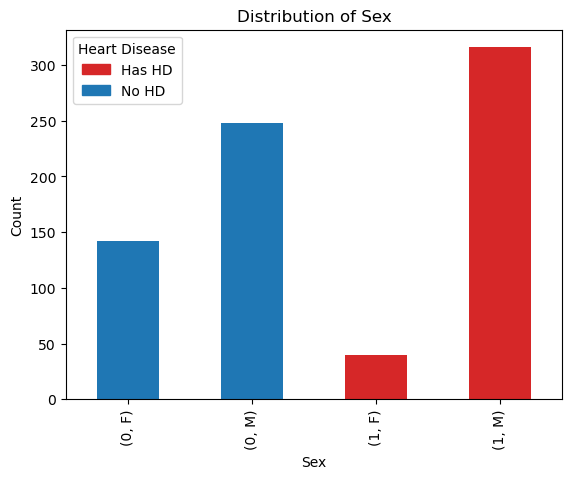

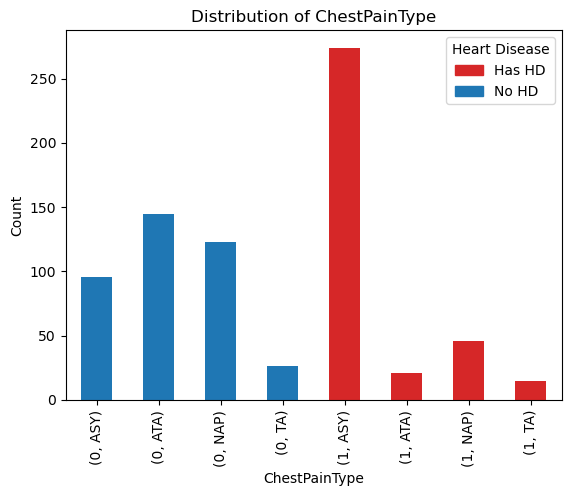

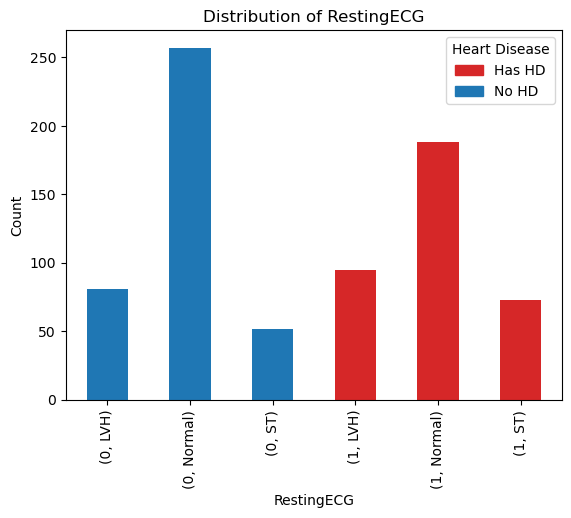

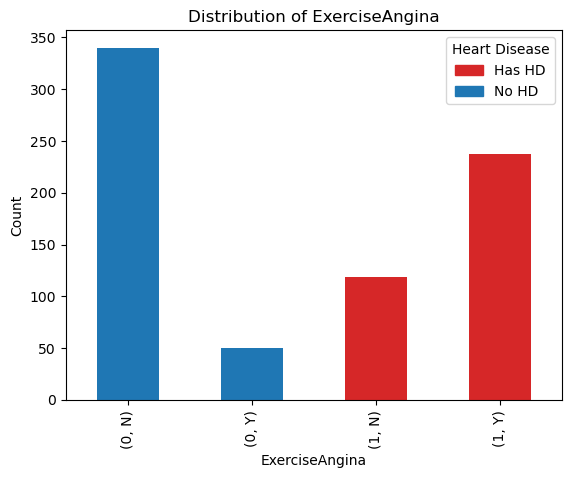

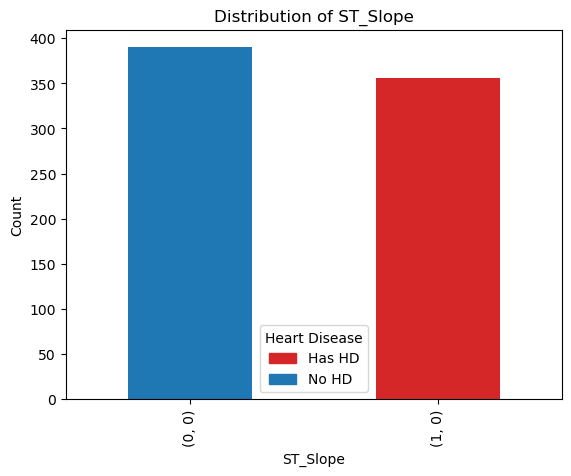

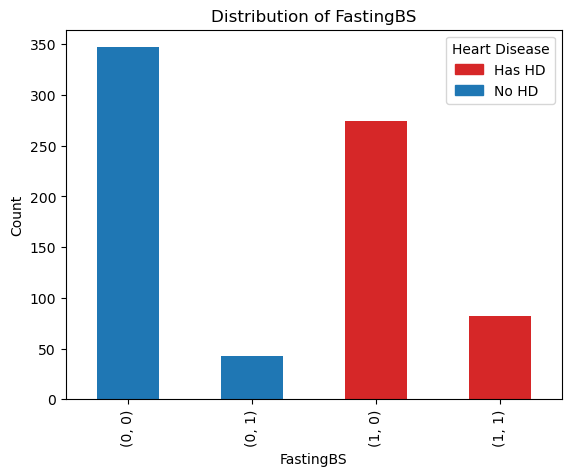

In [57]:
import matplotlib.patches as mpatches
for col in catCols:
    val_counts = df.groupby('HeartDisease')[col].value_counts().sort_index()
    colors = ['tab:red' if idx[0]==1 else 'tab:blue' for idx in val_counts.index]
    val_counts.plot(kind='bar', color=colors)
    plt.xlabel(col)
    plt.ylabel('Count')
    
    red_patch = mpatches.Patch(color='tab:red', label='Has HD')
    blue_patch = mpatches.Patch(color='tab:blue', label='No HD')
    plt.legend(handles=[red_patch, blue_patch], title="Heart Disease")
    
    plt.title(f'Distribution of {col}')
    plt.show()

A few things I noticed immediately were: 
- The rate of heart disease is much higher in the male patients than it is in the female patients.
- The rate of heart disease is very high in patients that have the ASY chest pain

Finally, I'll look at how these distributions look for the age of the patients

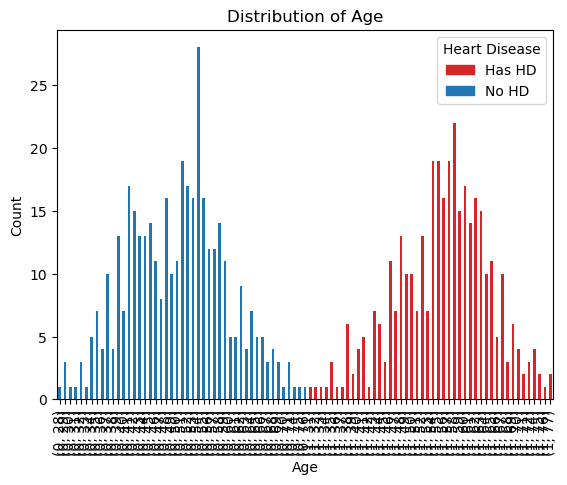

In [59]:
col = 'Age'

val_counts = df.groupby('HeartDisease')[col].value_counts().sort_index()
colors = ['tab:red' if idx[0]==1 else 'tab:blue' for idx in val_counts.index]
val_counts.plot(kind='bar', color=colors)
plt.xlabel(col)
plt.ylabel('Count')

red_patch = mpatches.Patch(color='tab:red', label='Has HD')
blue_patch = mpatches.Patch(color='tab:blue', label='No HD')
plt.legend(handles=[red_patch, blue_patch], title="Heart Disease")

plt.title(f'Distribution of {col}')
plt.show()

While it is hard to read the actual ages on the plot below, I do know that the distribution of the age of patients is normally distributed around the mean (53.5), and it looks like for both populations (has HD/doesn't have HD), there seems to be a normal distribution around that same mean age. There may also be two peaks in the population without HD

Given that the age distribution looks similar between HD/no HD patients, it suggests that age will not be a huge factor in predicting whether a patient will have HD or not.

## Data Cleaning

Earlier, I noticed that there were some values that didn't make sense (BP and Cholesterol having values of 0). I am going to go in and remove those rows as they will mess with the ML model otherwise, and decrease the accuracy of the model.

I will also be creating dummy columns for the categorical features.

In [18]:
df['RestingBP'].value_counts()[0]

1

In [19]:
df['Cholesterol'].value_counts()[0]

172

In [20]:
df = df.loc[df['RestingBP'] != 0]
df = df.loc[df['Cholesterol'] != 0]

In [21]:
df_dum = pd.get_dummies(df, columns=catCols)
dumCols = [col for col in df.columns if "_" in col]
for col in dumCols:
    df[col] = [1 if x==True else 0 for x in df[col]]

In [22]:
corrMat = df_dum.corr()

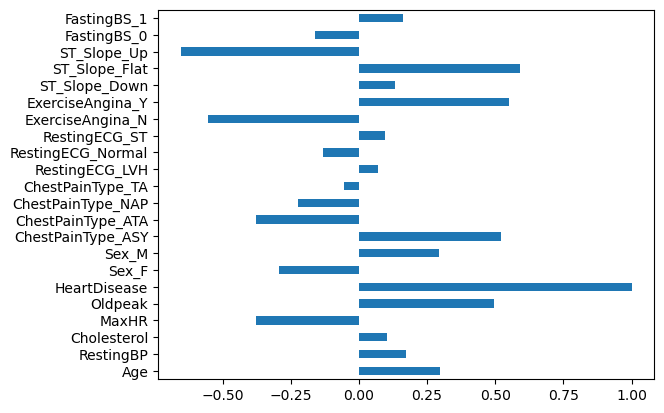

In [23]:
import seaborn as sns

# creating this target variable to make it easier to type target column
target = 'HeartDisease'

corrMat.loc[target].plot(kind='barh')
plt.show()

Looking at the correlation coefficients above, I will down-select to only a few features to focus the study on. I will only be looking at features that have a 0.3 or greater magnitude correlation coefficient. The focus features will be the following:
- ST_Slope_Up
- ST_Slope_Flat
- ExerciseAngina_Y (I will ignore ExerciseAngina_N because it is just the opposite and will do the same for similar situations for other features)
- ChestPainType_ATA
- ChestPainType_ASY
- Oldpeak
- MaxHR
- Sex_M (although the correlation coeff < 0.3, I will continue to focus on it given the much higher rate of HD in males vs females that I saw earlier)

In [25]:
focusCols = [col for col in corrMat.columns if abs(corrMat.loc[target][col])>0.3 and abs(corrMat.loc[target][col])<1]
focusCols.remove('ExerciseAngina_N')
focusCols += ['Sex_M']

## Creating the Model

I will now instantiate a KNN classifier to learn on the training data. I will be normalizing/scaling the data beforehand, so that the range of data in each feature is weighed equally.

In [27]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
testSize = 0.15
rand = 400 #arbitrary

X, y = df_dum.drop(target, axis=1), df_dum[target]
X_train, X_val, y_train, y_val = train_test_split(X[focusCols], y, test_size=testSize, random_state=rand)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[focusCols])
X_val_scaled = scaler.transform(X_val[focusCols])

For now, I will be using arbitrary ("normal") values for my model's **hyperparameters.** I will optimize these later.

In [29]:
classer = KNeighborsClassifier(n_neighbors=10)
# classer = KNeighborsClassifier(n_neighbors=15, weights='distance', p=5)
classer.fit(X_train_scaled, y_train)
acc = classer.score(X_val_scaled, y_val)
print(f"Model Accuracy: {acc}")
    

Model Accuracy: 0.8392857142857143


The model is already at a ~84% accuracy after testing it on the validation dataset. This is fairly high, especially considering that I haven't optimized the hyperparameters yet.

## Hyperparameter Optimization

I will be using GridSearchCV to quickly iterate through different values for my hyperparameters to try to improve my model's performance.

In [31]:
# Recreating these variables but this time with test values since GridSearchCV already creates its own validation tests
X_train, X_test, y_train, y_test = train_test_split(X[focusCols], y, test_size=testSize, random_state=rand)
X_test_scaled = scaler.transform(X_test)

grid_params = {
                "n_neighbors": range(1, 100),
                "metric": ["minkowski", "manhattan"],
                "weights":['uniform', 'distance']
              }

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train)
estimator = knn_grid.best_estimator_
print(f"Model Parameters: {estimator.get_params()}")
print(f"Model Validation Accuracy: {knn_grid.best_score_}")

Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 32, 'p': 2, 'weights': 'uniform'}
Model Validation Accuracy: 0.8723034620672416


After tuning the hyperparameters, it looks like the best performing version of the model has a **~87%** accuracy on its own created validation set. It seems that tuning the hyperparameters did help to improve the model's accuracy, but we will find that out for sure when it's tested on the actual test data.

In [33]:
print(f"Tuned Model Test Accuracy: {estimator.score(X_test_scaled, y_test)}")

Tuned Model Test Accuracy: 0.8660714285714286


The tuned model achieved a similarly **high accuracy of 86.6%**, a little lower than what it was with the validation set, but still higher than the model pre-optimization.

## Limitations
As I pointed out earlier, the data is disproportionately Male, and so it might suggest that we can't have the same confidence in the model's accuracy with females as we do with males. With that said, the distribution of males and females skews higher for females in the test set than it does in the training or original dataset, and we still see a high accuracy, which bodes well for the model


In [35]:
norm = True
print(f"{X.Sex_M.value_counts(normalize=norm)}")
print(f"{X_train.Sex_M.value_counts(normalize=norm)}")
print(f"{X_test.Sex_M.value_counts(normalize=norm)}")

Sex_M
True     0.756032
False    0.243968
Name: proportion, dtype: float64
Sex_M
True     0.76183
False    0.23817
Name: proportion, dtype: float64
Sex_M
True     0.723214
False    0.276786
Name: proportion, dtype: float64


While 87% accuracy is pretty high for a predictive model, in a medical application such as this one, especially when the predictions are on life-altering things, there is very litte room for error. 

***Only*** using a machine learning model to predict whether or not someone has heart disease could have devastating consequences if missed, so it is always important--in these applications--to have someone constantly verifying the results and feeding that information back to the model to also help further improve the model.